# IMEC2201 Herramientas Computacionales 
## Semana 3: Interpolación y Curva de Bomba
### Clase 6: Curva de Bomba Centrífuga

Universidad de los Andes — Abril 20, 2022.

---

## TABLA DE CONTENIDO

### Sección 1: Interpolación [→](#section1)
- 1.1. Cargar Librerías
- 1.2. Interpolación Lineal
- 1.3. Interpolación con Splines
- 1.4. Splines 1D
- 1.5. ¿Matemáticamente?
___

**¡Importante!** Note que la carpeta **week3** contiene dos archivos: `Project.toml` y `Manifest.toml`. Estos configuran el <font color="#FF5733">*ambiente de trabajo*</font> y facilitan el manejo de <font color="#FF5733">librerías</font>.

Para inicializar el ambiente desde Julia REPL, dentro de la carpeta **week2**, ejecute lo siguiente:

```shell
$ (v1.7) pkg > activate .
$ (week2) pkg> instantiate
```

**Nota:** Para acceder al Pkg REPL, escriba el corchete derecho `]` en el Julia REPL. Note que el REPL cambie de color de verde (Julia REPL) a azul (Pkg REPL). Una vez ejecutado el código `activate .`, el prefijo entre paréntesis indica el ambiente activo: cambia de `v1.7` a `week2`.

O, desde Jupyter Notebook, ejecute:

```julia
$ using Pkg
$ Pkg.activate()
$ Pkg.instantiate()
```

**Nota:** La activación del ambiente <font color="#FF5733">*precompila*</font> las librerías por lo que puede tardar un momento su ejecución completa.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información en la documentación oficial de la librería [`Pkg.jl`](https://pkgdocs.julialang.org/v1/environments/) y en el documento dando clic [aquí](https://towardsdatascience.com/how-to-setup-project-environments-in-julia-ec8ae73afe9c).
</div>

In [1]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/ua-imec2001-hc-202210/content/week3`


In [2]:
Pkg.status()

      Status `~/Documents/GitHub/ua-imec2001-hc-202210/content/week3/Project.toml`
  [336ed68f] CSV v0.10.4
  [a93c6f00] DataFrames v1.3.3
  [39dd38d3] Dierckx v0.5.2
  [a98d9a8b] Interpolations v0.13.6
  [91a5bcdd] Plots v1.27.5
  [fdbf4ff8] XLSX v0.7.9


<a id="section1"></a>
# Sección 1: Bomba Centrífuga

## 1.1. Introducción

Una bomba es un dispositivo que **añade energía a un fluido**. Hablando específicamente de la bombas centrífugas, estas añaden una cantidad de movimiento al fluido por medio de paletas, también llamados álabes. 

<img src='./img/centrifugal_pump.gif' width='250' height='250' />

Las bombas centrífugas proporcionan grandes caudales (hasta 300.000 gal/min) con bajos incrementos de presión (pocas atmósferas).<br><br>


De manera general, el flujo de la operación es:
> - **Paso 1.** El fluido entra axialmente a través del ojo, en el eje de la carcasa.
> - **Paso 2.** Los álabes del rotor fuerzan el fluido a tomar un movimiento tangencial y radial hacia el exterior del rotor, donde es recogido por una carcasa que hace de difusor.
> - **Paso 3.** El fluido aumenta su velocidad y presión cuando pasa a través del rotor.
> - **Paso 4.** La parte de la carcasa, con forma de voluta, decelera el flujo y aumenta más la presión.

<img src='./img/esquematico.png' width='500' height='500' />

## 1.2. Parámetros de Estudio

La potencia que la bomba centrífuga le añade al fluido (conocida como **potencia hidráulica** $P_w$), es:

$$
P_w = \rho g Q H
$$

Donde $\rho$ es la densidad del fluido, $g$ la gravedad, $Q$ el caudal y $H$ la altura manométrica, definida como:

$$
H = \frac{\Delta p}{\rho g}
$$

Siendo $\Delta p$ el cambio de presión entre la entrada y salida de la bomba centrífuga.

Ahora bien, para que la bomba centrífuga le añada energía al fluido, debe haber un recurso que, asimismo, le suministre energía al dispositivo. Esto último es conocido como **potencia mecánica** $P_f$ y es el producto entre la velocidad de rotación del eje de la bomba $w$ y el torque en el mismo $T$.

$$
P_f = w T
$$

Luego, si el insumo es $P_f$ y la salida es $P_w$, la eficiencia de la bomba es la relación entre estos parámetros, es decir:

$$
\eta = \frac{P_w}{P_f} = \frac{\rho g Q H}{w T}
$$

Entonces, el rendimiento de la bomba centrífuga depende de tres factores: volumétrico, hidráulico y mecánico. 

## 1.3. Curvas Características

Las curvas características de las bombas centrífugas se trazan para velocidad de giro $n$ constante del eje (en RPM). El caudal $Q$ (en gal/min o gpm) se toma como variable independiente, es decir, se ubica en el eje horizontal. 

Las variables dependientes (se ubican en el eje vertical) son:
- Altura manométrica $H$.
- Potencia mecánica $P_f$.
- Eficiencia $\eta$.

<img src='./img/curvas_teoricas.png' width='400' height='400' />

En la práctica, aunque las curvas de la altura manométrica $H$ aparecen explícitamente, las de potencia $P_f$ y rendimiento $\eta$ deben deducirse a partir de los datos medidos. Fíjense, **es como los laboratorios que hacemos en los cursos de ingeniería mecánica**.

<img src='./img/curvas_reales.png' width='900' height='900' />

La variable $NPSH$ (*Net-Positive Suction Head*) es la **altura neta de succión**, también llamada **cabeza** neta de succión, y establece el valor de presión disponible a la entrada de la bomba para evitar la cavitación o evaporación del líquido.

$$
NPSH = \frac{p_{in}}{\rho g} + \frac{V_{in}^2}{2g} - \frac{p_{vapor}}{\rho g}
$$

<img src='./img/npsh.png' width='400' height='400' />

# Sección 2. Puesta en Práctica

## 2.1. Cargar Librerías

In [3]:
using Plots
using Dierckx
using DataFrames
using Interpolations

## 2.2. Conjunto de Datos a Interpolar

Conformemos entonces la nube de puntos para un diámetro derotor de 36 3/4 in. Empecemos con tres datos (a ver qué tal) y luego aumentamos dos puntos más.

<img src='./img/curva_practica.png' width='500' height='500' />

In [4]:
Q = [0.0, 6.0, 12.0, 20.0, 26.0] # gal/min
H = [655.0, 645.0, 620.0, 560.0, 460.] # ft

df = DataFrame(Caudal = Q,
               Altura = H)

df

,Caudal,Altura
,Float64,Float64
1,0.0,655.0
2,6.0,645.0
3,12.0,620.0
4,20.0,560.0
5,26.0,460.0


## 2.3. Interpolación Lineal

Como vimos en la Clase 5 (`C5_interpolacion`), con la librería `Interpolations.jl` utilizamos la función `LinearInterpolation`. La sintaxis de esta función consiste en:

1. Definir el interpolador mediante `LinearInterpolation(x,y)`.
2. Ejecutar la función determinada por el interpolador en el conjunto de puntos independiente mediante.

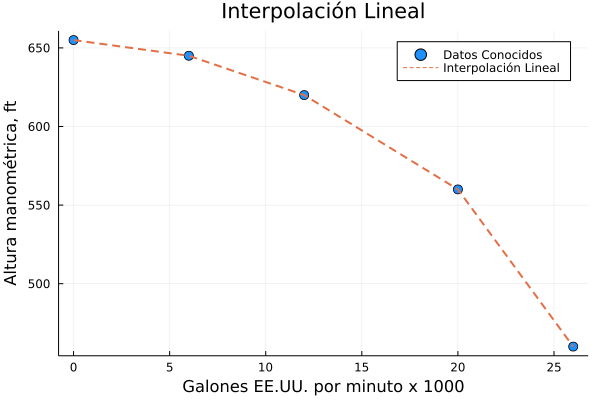

In [5]:
x = df."Caudal"
y = df."Altura"

# Interpolación lineal
itp_lineal = LinearInterpolation(x, y)

# Ejecución del interpolador
f_lineal(x) = itp_lineal(x)

# Gráficas
plot(x, y, seriestype=:scatter, m=:circle, ms=5, mc=:dodgerblue, label="Datos Conocidos", legend=true)
plot!(x, f_lineal, seriestype=:line, ls=:dash, w=2, m=:none, ms=5, label="Interpolación Lineal", legend=true)

title!("Interpolación Lineal")
xlabel!("Galones EE.UU. por minuto x 1000")
ylabel!("Altura manométrica, ft")

En este caso, si quisiera conocer el valor en un punto dado, debo utilizar la misma función, indicando el valor de interés, es decir: `LinearInterpolation(x)`.

Por ejemplo, recreemos los puntos para el rango completo de caudal, es decir, $Q \in {[0, 26]}$.

In [6]:
x_interes = 20
y_interes = itp_lineal(x_interes)

560.0

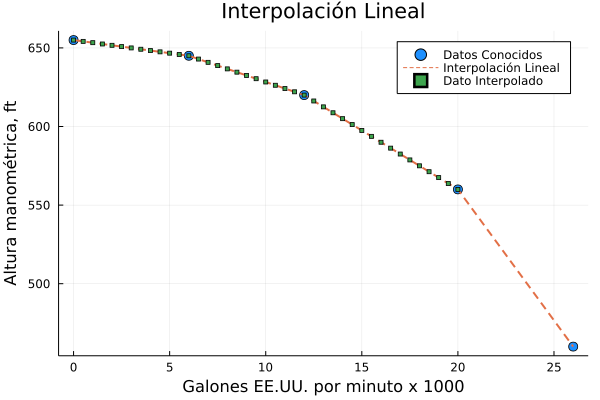

In [7]:
x_interes = collect(0:0.5:20)

y_interes = []
for i in x_interes
    push!(y_interes, itp_lineal(i))
end

plot!([x_interes], [y_interes], seriestype=:scatter, m=:rect, ms=2, label="Dato Interpolado", legend=true)

Ahora, si deseamos estudiar la relación entre el caudal $Q$ y la potencia mecánica $P_w$, deberíamos tener un comportamiento similar al siguiente:

<img src='./img/curvas_teoricas.png' width='400' height='400' />

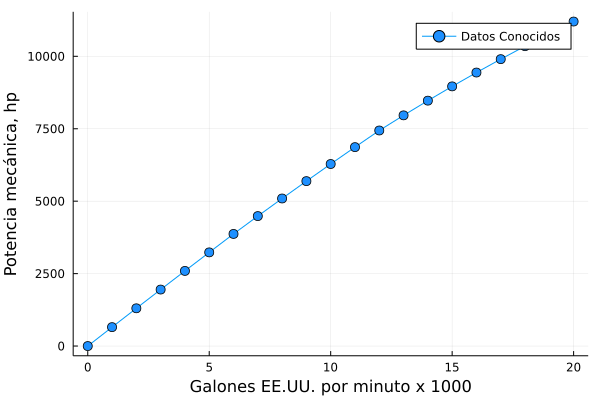

In [8]:
Q_estudio = collect(0:1:20)

H_itp = []
for i in Q_estudio
    push!(H_itp, itp_lineal(i))
end
    
Pf = Q_estudio .* H_itp

# Gráficas
plot(Q_estudio, Pf, seriestype=:line, m=:circle, ms=5, mc=:dodgerblue, label="Datos Conocidos", legend=true)

xlabel!("Galones EE.UU. por minuto x 1000")
ylabel!("Potencia mecánica, hp")

## 2.4. Interpolación con Splines

En ingeniería, y en específico en los cursos de ingeniería mecánica, de los datos obtenidos de un experimento se crea una tabla de valores, a partir de la cual muchas veces se necesita conocer a qué función matemática pertenece.

Recordemos que por interpolación se entiende **estimar el valor desconocido de una función también desconocida en un punto**, es decir, ¿cuánto "*vale*" el valor aproximado de "*y*", a partir de “*x*”, o viceversa, si se desconoce la función?

Como hemos visto, la interpolación, como método numérico, genera una medida ponderada de sus valores conocidos en puntos cercanos al punto dado. También, la interpolación resuelve el problema referido a encontrar un polinomio que
pase por puntos dados $(x_i,\:y_i)$.

Esto es, permite a partir de los puntos dados, encontrar una función aproximada (un polinomio) que define el fenómeno, y que pasa exactamente por esos puntos. Así, se puede conocer parte del comportamiento de la función desconocida $f(x)$.

Por último, recordemos también que un *spline* es una curva suave definida en partes mediante diferentes polinomios.

En este caso, con la librería `Dierckx.jl` utilizamos la función `Spline1D`.

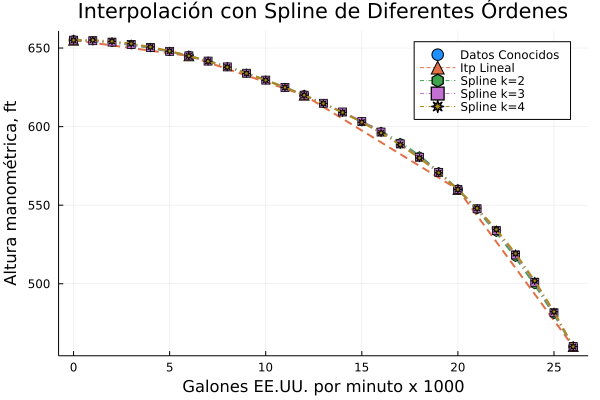

In [9]:
# Interpolación Spline de Orden k (k debe ser menor a la cantidad de datos)
spl2 = Spline1D(x, y, k=2) 
spl3 = Spline1D(x, y, k=3) 
spl4 = Spline1D(x, y, k=4)
#spl5 = Spline1D(x, y, k=3) 

# Ejecución del interpolador
f_spline2(x) = spl2(x)
f_spline3(x) = spl3(x)
f_spline4(x) = spl4(x)
#f_spline5(x) = spl5(x)

# Cualquier valor de X a evaluar
x_eval = collect(x[1]:1:x[end])

# Gráficas
plot(x, y, seriestype=:scatter, m=:circle, ms=5, mc=:dodgerblue, label="Datos Conocidos", legend=true)
plot!(x, f_lineal, seriestype=:line, ls=:dash, w=2, m=:utriangle, ms=5, label="Itp Lineal", legend=true)
plot!(x_eval, f_spline2, seriestype=:line, ls=:dashdot, m=:hexagon, w=2, label="Spline k=2", legend=true)
plot!(x_eval, f_spline3, seriestype=:line, ls=:dashdot, m=:rect, w=2, label="Spline k=3", legend=true)
plot!(x_eval, f_spline4, seriestype=:line, ls=:dashdot, m=:star8, w=2, label="Spline k=4", legend=true)
#plot!(x, f_spline5, seriestype=:line, ls=:dashdot, w=2, m=:none, ms=5, label="Dierckx Spline k=5", legend=true)

title!("Interpolación con Spline de Diferentes Órdenes")
xlabel!("Galones EE.UU. por minuto x 1000")
ylabel!("Altura manométrica, ft")

Utilizando el ejemplo sinusoidal de la clase anterior, vemos lo siguiente:

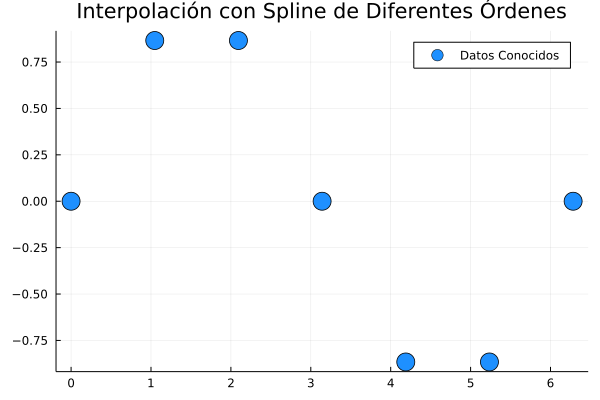

In [10]:
# Límite inferior y superior del intervalo
a = 0.0
b = 2π
ndatos = 7

# Definición del intervalo
x = collect(range(a, stop=b, length=ndatos))

# Función que originalmente desconocemos
y = sin.(x)

# Interpolación lineal
itp_lineal = LinearInterpolation(x, y)

# Interpolación Spline de Orden k (k debe ser menor a la cantidad de datos)
spl2 = Spline1D(x, y, k=2)
spl3 = Spline1D(x, y, k=3) 
spl4 = Spline1D(x, y, k=4)
#spl5 = Spline1D(x, y, k=3) 

# Ejecución del interpolador
f_lineal(x) = itp_lineal(x)

# Ejecución del interpolador
f_spline2(x) = spl2(x)
f_spline3(x) = spl3(x)
f_spline4(x) = spl4(x)

# Cualquier valor de X a evaluar
x_eval = collect(range(x[1], stop=x[end], length=50))

# Gráficas
plot(x, y, seriestype=:scatter, m=:circle, ms=10, mc=:dodgerblue, label="Datos Conocidos", legend=true)
#plot!(x, f_lineal, seriestype=:line, ls=:solid, w=2, m=:utriangle, ms=3, label="Itp Lineal", legend=true)
#plot!(x_eval, f_spline2, seriestype=:line, ls=:auto, m=:hexagon, w=2, label="Spline k=2", legend=true)
#plot!(x_eval, f_spline3, seriestype=:line, ls=:auto, m=:rect, w=2, label="Spline k=3", legend=true)
#plot!(x_eval, f_spline4, seriestype=:line, ls=:auto, m=:star8, w=2, label="Spline k=4", legend=true)

title!("Interpolación con Spline de Diferentes Órdenes")

## 2.5. Evaluemos el Comportamiento de la Bomba Centrífuga

La potencia que la bomba centrífuga le añade al fluido (conocida como **potencia hidráulica** $P_w$), es:

$$
P_w = \rho g Q H
$$

Donde $\rho$ es la densidad del fluido, $g$ la gravedad, $Q$ el caudal y $H$ la altura manométrica, definida como:

$$
H = \frac{\Delta p}{\rho g}
$$

Siendo $\Delta p$ el cambio de presión entre la entrada y salida de la bomba centrífuga.

Ahora bien, para que la bomba centrífuga le añada energía al fluido, debe haber un recurso que, asimismo, le suministre energía al dispositivo. Esto último es conocido como **potencia mecánica** $P_f$ y es el producto entre la velocidad de rotación del eje de la bomba $w$ y el torque en el mismo $T$.

$$
P_f = w T
$$

Luego, si el insumo es $P_f$ y la salida es $P_w$, la eficiencia de la bomba es la relación entre estos parámetros, es decir:

$$
\eta = \frac{P_w}{P_f} = \frac{\rho g Q H}{w T}
$$

Entonces, el rendimiento de la bomba centrífuga depende de tres factores: volumétrico, hidráulico y mecánico. 

Para las mediciones de los datos de caudal $Q$ y, sabiendo que la velocidad de rotación del eje de la bomba $w$ es 1170 rpm y la eficiencia $\eta$ es 82$\%$, verifiquemos la relación entre caudal $Q$ y torque $T$. Asumimos $\rho g = 1$. Para esto:

$$
\eta = \frac{P_w}{P_f} = \frac{\rho g Q H}{w T}
$$

Luego:

$$
T = \frac{\rho g Q H}{w \eta} = \frac{Q H}{1170 \cdot 0.82}
$$

Comparemos los resultados si utilizamos una **interpolación lineal** y ***spline* cúbica**.

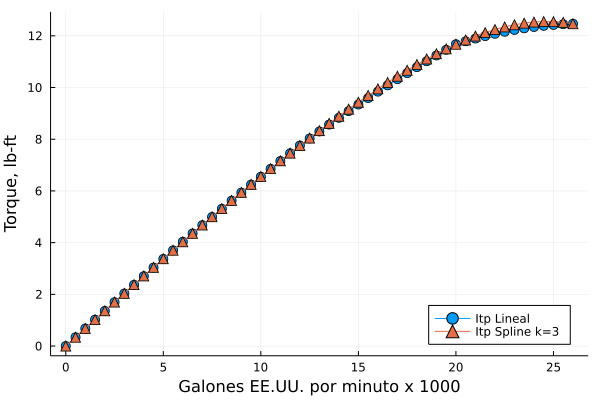

In [19]:
x = df."Caudal"
y = df."Altura"

# Interpolación lineal
itp_lineal = LinearInterpolation(x, y)

# Interpolación Spline de Orden k (k debe ser menor a la cantidad de datos)
spl3 = Spline1D(x, y, k=3) 

# Ejecución del interpolador
f_lineal(x) = itp_lineal(x)
f_spline3(x) = spl3(x)

# Cualquier valor de X a evaluar
x_eval = collect(range(x[1], stop=x[end], length=50))

# Ecuación de Relación T vs Q
Q_estudio = collect(0:0.5:26)

H_itp = []
H_spl = []
for i in Q_estudio
    push!(H_itp, itp_lineal(i))
    push!(H_spl, spl3(i))
end
    
T_itp = (Q_estudio .* H_itp) ./ (1170 .* 0.82)
T_spl = (Q_estudio .* H_spl) ./ (1170 .* 0.82)

# Gráficas
plot(Q_estudio, T_itp, seriestype=:line, m=:circle, ms=5, label="Itp Lineal", legend=:bottomright)
plot!(Q_estudio, T_spl, seriestype=:line, m=:utriangle, ms=5, label="Itp Spline k=3", legend=:bottomright)

xlabel!("Galones EE.UU. por minuto x 1000")
ylabel!("Torque, lb-ft")